# Isochrone Map for Ward 8

I will use the information from the notebook, "vehicle_access_clean" where we found a variety of areas that are more than 10 minutes walking from a grocery store and have over 50% of households lacking vehicle access. I found the centroids of the polygons where these areas overlap and will use the following point randomly pulled from the list:

88     POINT (-77.00306 38.83097)

Taking this point, let's recreate the isochrone map for Ward 8. Note that because of the overwhelming complexity of the function that I would need to generate to create multiple isochrone maps, I've opted to copy over the information from the Ward 2 Isochrone map and change the point used for longitude and latitude. All other code is the same. 

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

Setting the parameters to calculate travel times for walking distance.

In [2]:
latlon= [38.83097, -77.00306]
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

Creating the graph variable to pull nodes and edges from.

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

Convert to a distance based coordinate system (EPSG:3857)

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

Adding the edges and nodes to use to calculate travel times.

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

Let's find the boundaries of the min and max coordinates of the polygon to find the centroid.

In [6]:
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-8573700.265546476
4694922.986168832
-8569381.637033101
4700057.279106445


We'll calculate an average point that will become the centroid.

In [7]:
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-8571540.951289788
4697490.132637639


Tying this centroid to the nearest node:

In [8]:
ward8_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(ward8_node))

The id for the nearest node is 1468856024


Let's calculate walk times around this node.

In [9]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [10]:
cmap = 'YlGn'

Just want to double check that trip times are 5, 10, and 15 minutes.

In [11]:
trip_times

[5, 10, 15]

Double checking what colors are being used for each:

In [12]:
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#ffffe5', '#77c679', '#004529']


I actually want to invert these colors so that the dark green shows 5 minutes (#004529) while the lighter color reflects 15 minutes away.

In [13]:
new_colors=['#004529','#77c679','#ffffe5']
print(new_colors)

['#004529', '#77c679', '#ffffe5']


Let's try to zip these now to pair the list of trip times with the assigned colors:

In [14]:
time_color = list(zip(trip_times, new_colors))
time_color

[(5, '#004529'), (10, '#77c679'), (15, '#ffffe5')]

In [15]:
time_color.reverse()
time_color

[(15, '#ffffe5'), (10, '#77c679'), (5, '#004529')]

We want to create a for loop that connects each node within a time frame to a certain color. We'll create an egograph of nodes within this distance and then update the data frame for gdf_nodes with an associated distance color.

In [16]:
for time, color in list(time_color):
  
    subgraph = nx.ego_graph(G, ward8_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 667 nodes within 15 minutes #ffffe5
There are 211 nodes within 10 minutes #77c679
There are 53 nodes within 5 minutes #004529


Let's add a gray color for nodes that are outside fo the 15 minute walk watershed.

In [17]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)
gdf_nodes.sample(10)

,y,x,street_count,lon,lat,highway,geometry,time,color
osmid,,,,,,,,,
5443092239,4.697146e+06,-8.571412e+06,3,-76.998303,38.828573,NaN,POINT (-8571411.871 4697145.860),10.0,#77c679
5443092243,4.697148e+06,-8.571624e+06,1,-77.000206,38.828586,NaN,POINT (-8571623.723 4697147.646),15.0,#ffffe5
5442856251,4.699522e+06,-8.571353e+06,1,-76.997774,38.845202,NaN,POINT (-8571352.983 4699522.281),NaN,#cccccc
1496803750,4.699390e+06,-8.570878e+06,4,-76.993511,38.844279,NaN,POINT (-8570878.461 4699390.401),NaN,#cccccc
7266477548,4.699693e+06,-8.569852e+06,3,-76.984290,38.846397,NaN,POINT (-8569851.995 4699693.026),NaN,#cccccc
49773671,4.698835e+06,-8.571665e+06,3,-77.000573,38.840393,stop,POINT (-8571664.577 4698834.957),15.0,#ffffe5
49782678,4.696920e+06,-8.572569e+06,3,-77.008702,38.826996,NaN,POINT (-8572569.493 4696920.444),NaN,#cccccc
49782687,4.696921e+06,-8.573002e+06,3,-77.012587,38.826997,NaN,POINT (-8573001.970 4696920.587),NaN,#cccccc
9389155250,4.697476e+06,-8.571434e+06,4,-76.998501,38.830885,NaN,POINT (-8571433.879 4697476.212),5.0,#004529


Let's plot the nodes to see what we get.

<AxesSubplot: >

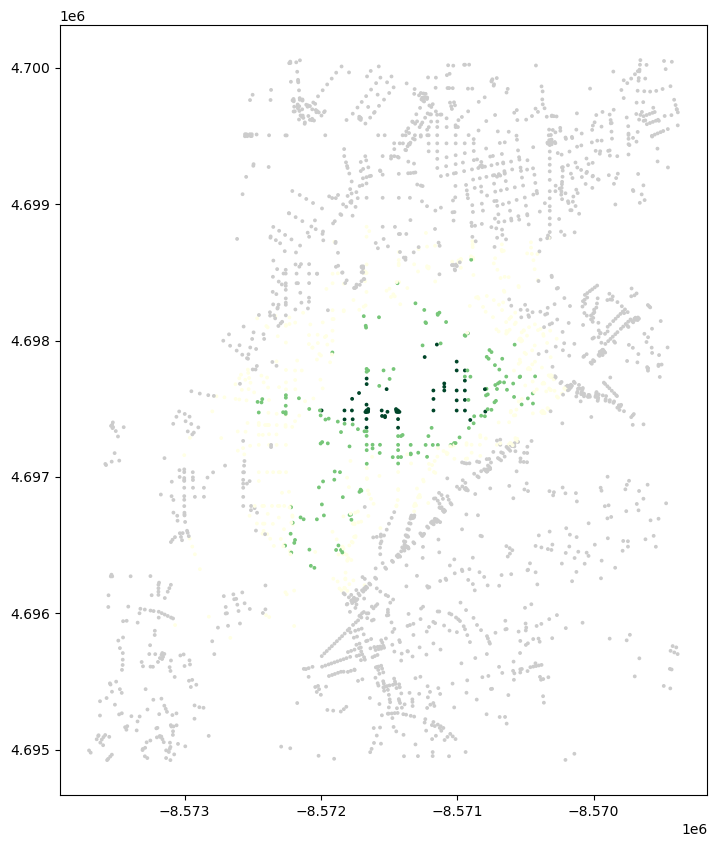

In [18]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

Creating a sample of nodes within 5 minutes walking distance.

In [19]:
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

Let's plot it and see what points are formed...

<AxesSubplot: >

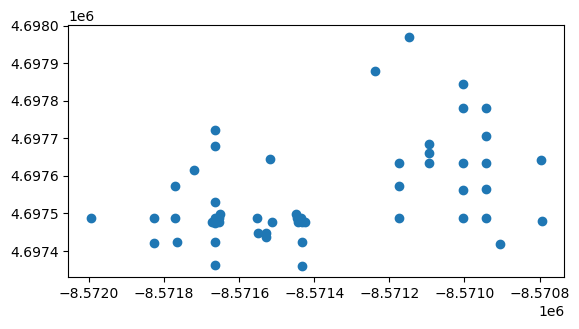

In [20]:
gdf_5.plot()

Let's see the shape that's created from these nodes using Convex Hull.

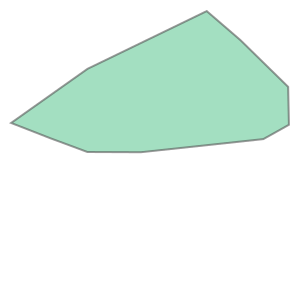

In [21]:
gdf_5.unary_union.convex_hull

Well....that's something. Let's hope the other shapes provide more insight into what's going on around this Safeway. I'll use dissolve for this next part to create polygons around the 5, 10, and 15 minute nodes.

In [22]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

,geometry,y,x,street_count,lon,lat,highway,color
time,,,,,,,,
5.0,"MULTIPOINT (-8571994.639 4697487.558, -8571826...",4.697488e+06,-8.571995e+06,4,-77.003538,38.830965,traffic_signals,#004529
10.0,"MULTIPOINT (-8572463.851 4697550.377, -8572455...",4.697550e+06,-8.572464e+06,4,-77.007753,38.831404,traffic_signals,#77c679
15.0,"MULTIPOINT (-8573069.006 4695913.529, -8573001...",4.697763e+06,-8.572533e+06,3,-77.008374,38.832895,traffic_signals,#ffffe5


We'll convert each row into a convex hull now using the geometry of the multiple nodes.

In [23]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

,time,geometry
0,5.0,"POLYGON ((-8571433.611 4697361.006, -8571664.8..."
1,10.0,"POLYGON ((-8572047.282 4696333.358, -8572073.2..."
2,15.0,"POLYGON ((-8572663.970 4695819.573, -8573069.0..."


Now, I'll reverse the order so the 15 minute polygon is mapped first.

In [24]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones

,time,geometry
2,15.0,"POLYGON ((-8572663.970 4695819.573, -8573069.0..."
1,10.0,"POLYGON ((-8572047.282 4696333.358, -8572073.2..."
0,5.0,"POLYGON ((-8571433.611 4697361.006, -8571664.8..."


Time to plot it and see what is produces!

<AxesSubplot: >

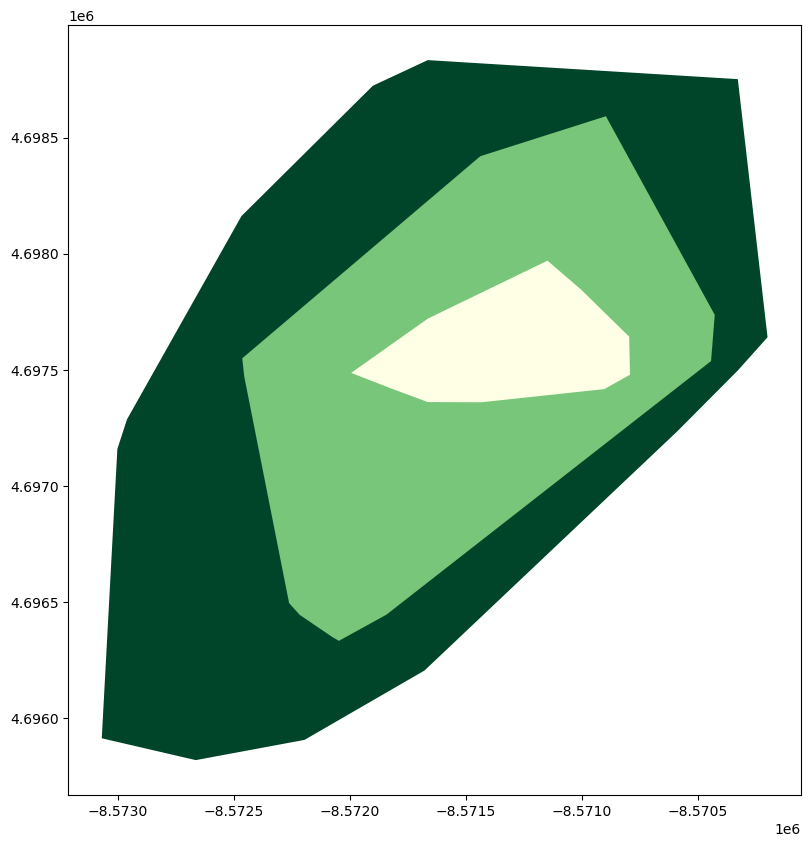

In [25]:
isochrones.plot(figsize=(10,10),alpha=1,color=new_colors, legend=True)

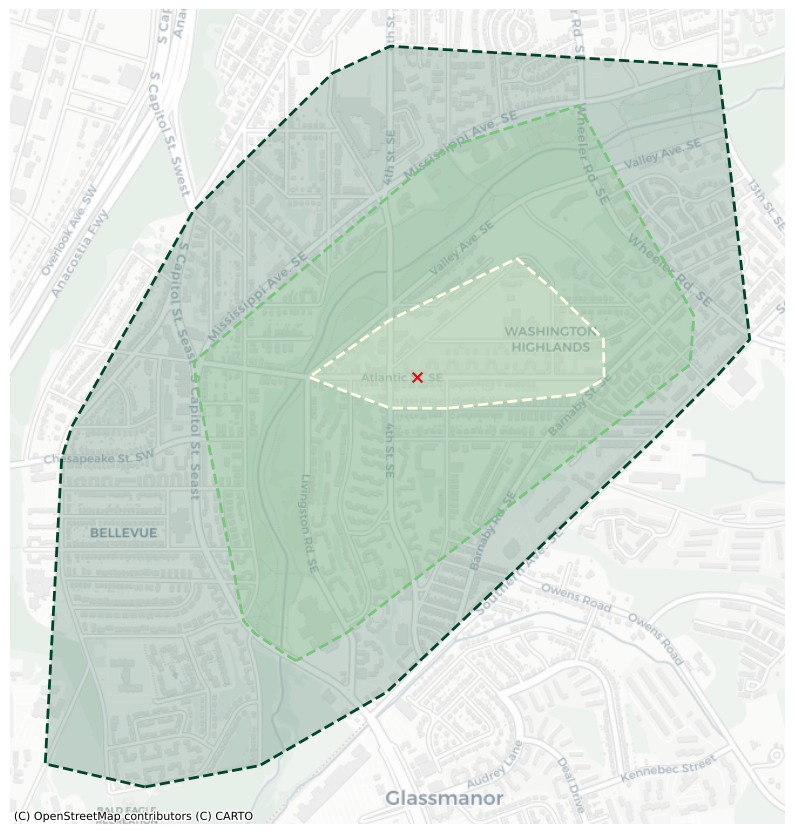

In [26]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=new_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=new_colors,
    )

# add the center node in red
gdf_nodes.loc[[ward8_node]].plot(ax=ax,color='r',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Adding in Food Environment Markers to Maps

Now, I'll quickly bring in the data for grocery stores, farmers markets, fast food, liquor licenses, and community gardens to plot them as markers within the isochrone map.

Let's start with grocery stores...

In [27]:
grocery = pd.read_csv('data/Grocery_Store_Locations.csv')

Don't need to clean up everything because I know that we just need the coordinates in order to map everything. I'll turn it into a geodata frame now.

In [28]:
gdf_grocery = gpd.GeoDataFrame(grocery, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(grocery.X, grocery.Y))

In [29]:
gdf_grocery.head()

,X,Y,STORENAME,ADDRESS,ZIPCODE,PHONE,WARD,SSL,NOTES,PRESENT90,...,YCOORD,MAR_ID,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,PRESENT22,geometry
0,-77.026981,38.984455,Target,7828 GEORGIA AVENUE NW,20012,2028923822,Ward 4,2960 0017,NaN,NaN,...,146280.07,300512,NaN,{CE302122-4E8D-4DC7-845B-06563B993F66},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.027 38.984)
1,-77.026066,38.983464,International Progresso Market,7719 GEORGIA AVENUE NW,20012,2025455015,Ward 4,2961 0810,NaN,NaN,...,146169.97,285417,NaN,{2C18863D-40DE-4F66-AA59-46F1C65D67F2},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.026 38.983)
2,-77.027798,38.967771,Jocelyn’s Market,6404 GEORGIA AVENUE NW,20012,2027227574,Ward 4,2945 0839,NaN,NaN,...,144428.00,285334,NaN,{A0B448C3-B3FB-49FE-B8BF-1FEBA3CEA642},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.028 38.968)
3,-77.076459,38.965553,Magruder's,5626 CONNECTICUT AVENUE NW,20015,2024644946,Ward 3,1860 0013,,Yes,...,144184.19,263860,NaN,{9ABE1C46-BB48-4110-B5BA-C6363CA3BD7A},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.076 38.966)
4,-77.074910,38.964601,Safeway,5545 CONNECTICUT AVENUE NW,20015,2022446097,Ward 3,1867 0092,,No,...,144078.34,263999,NaN,{902F540E-FE16-43A5-8010-CD84E94B28B7},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.075 38.965)


Repeating the process of bringing in farmers markets and turning it into a geodata frame:

In [30]:
farmers = pd.read_csv('data/Farmers_Market_Locations.csv')

In [31]:
gdf_farmers=gpd.GeoDataFrame(farmers, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(farmers.X, farmers.Y))

In [32]:
gdf_farmers.head()

,X,Y,NAME,LAYER,THEME,IMAGE_,ADDRESS,PHONE,VOUCHERS,PRIORITY_LEVEL,...,SE_ANNO_CAD_DATA,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,LATITUDE,LONGITUDE,geometry
0,-77.075111,38.965166,Chevy Chase/Broad Branch Farmers' Market,Farmers Market,Local Business & Food,NaN,5601 Connecticut Ave. NW,NaN,NaN,NaN,...,NaN,FarmersMarketPt_9,{BA7F2149-421B-4053-9C2F-25BD6C2062D6},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.965159,-77.075109,POINT (-77.075 38.965)
1,-77.033134,38.955829,14th & Kennedy Farmers' Market,Farmers Market,Local Business & Food,NaN,5425 14th St NW,NaN,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_10,{81DB3732-F194-4E23-BD85-4C01FFBA5870},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.955822,-77.033132,POINT (-77.033 38.956)
2,-77.069967,38.947004,New Morning Farmers Market at the Sheridan School,Farmers Market,Local Business & Food,NaN,3600 Alton Place NW,814.448.3904,"Accepts WIC, senior farmers market nutrition p...",1.0,...,NaN,FarmersMarketPt_11,{A796CC2A-E688-4F90-8628-6B1B98172BC2},NaN,NaN,DCGIS,2018/01/03 16:49:14+00,38.946996,-77.069965,POINT (-77.070 38.947)
3,-77.064407,38.944128,UDC Farmers Market,Farmers Market,Local Business & Food,NaN,4200 Connecticut Ave NW,202-274-7148,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_12,{0EB6EBBC-82CC-40A2-B5D1-E9B94D306B24},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.944120,-77.064405,POINT (-77.064 38.944)
4,-77.024775,38.941371,Petworth Community Market,Farmers Market,Local Business & Food,NaN,4121 9th St NW,NaN,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_13,{77E47183-0DCC-4E49-BC54-56780B300A2B},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.941364,-77.024772,POINT (-77.025 38.941)


Let's repeat the importing and converting into a geodataframe process for fast food:

In [33]:
fast = pd.read_csv('data/Fast Food Data.csv')

In [34]:
fast.rename(columns={'Geometry':'geometry'}, inplace=True)
fast.rename(columns={'Store Name':'NAME'}, inplace=True)

Time to convert it into a geodata frame.

In [35]:
gdf_fast = gpd.GeoDataFrame(fast, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(fast.Longitude, fast.Latitude))

In [36]:
gdf_fast.head()

,NAME,Store Type,geometry,Latitude,Longitude,Address
0,McDonalds,fast food,POINT (-77.077 38.945),38.944559,-77.077161,"4130 Wisconsin Ave NW, Washington, DC 20016"
1,McDonalds,fast food,POINT (-77.026 38.983),38.982652,-77.025704,"7425 Georgia Ave NW, Washington, DC 20011"
2,McDonalds,fast food,POINT (-77.028 38.963),38.963234,-77.028193,"5948 Georgia Ave NW, Washington, DC 20011"
3,McDonalds,fast food,POINT (-77.052 38.927),38.926756,-77.051582,"2616 Connecticut Ave NW, Washington, DC 20008"
4,McDonalds,fast food,POINT (-77.042 38.924),38.923718,-77.042184,"2481-83 18th St NW, Washington, DC 20009"


I actually want to distinguish between "healthy" and "unhealthy" fast food so let me go ahead and create two separate variables for that.

In [37]:
fast_unhealthy=gdf_fast[gdf_fast['Store Type']=='fast food']
fast_healthy=gdf_fast[gdf_fast['Store Type']=='healthy fast food']

Repeat for liquor licenses:

In [38]:
liquor= pd.read_csv('data/Liquor_Licenses.csv')

In [39]:
gdf_liquor=gpd.GeoDataFrame(liquor, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(liquor.X, liquor.Y))

In [40]:
gdf_liquor.head()

,X,Y,LICENSE,APPLICANT,TRADE_NAME,CLASS,ADDRESS,ZIPCODE,WARD,ANC,...,LONGITUDE,LATITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,geometry
0,-77.045099,38.913006,ABRA-011228,R Street Restaurant Corporation,La Tomate,C,1701 CONNECTICUT AVENUE NW,20009,Ward 2,ANC 2B,...,-77.045097,38.912999,ABRALicenseePt_91,{3E350BC9-82F1-48D5-9A08-BDD89B642F69},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,4891,POINT (-77.045 38.913)
1,-77.049072,38.904526,ABRA-060273,"MPE Hotel I (Washington), LLC",Ritz Carlton Washington DC,C,1150 22ND STREET NW,20037,Ward 2,ANC 2A,...,-77.049070,38.904519,ABRALicenseePt_228,{68D32801-8631-4B1A-93FB-3313C7F6BBD5},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,5028,POINT (-77.049 38.905)
2,-77.031698,38.896532,ABRA-076197,"Lim Enterprises, Corp",Press Liquors,A,527 14TH STREET NW,20004,Ward 2,ANC 2C,...,-77.031695,38.896525,ABRALicenseePt_406,{F0CCB31F-D68E-47FA-8991-D8EC265259F1},JLAY,2022/08/31 18:04:53+00,JLAY,2023/02/03 22:20:23+00,5206,POINT (-77.032 38.897)
3,-77.021170,38.936862,ABRA-091449,"A & M, Inc.",Rock Creek Market,B,646 ROCK CREEK CHURCH ROAD NW,20010,Ward 1,ANC 1E,...,-77.021168,38.936854,ABRALicenseePt_777,{216F37CB-096C-4176-976B-3F31E89509B9},JLAY,2022/08/31 18:04:53+00,JLAY,2023/02/03 22:20:23+00,5577,POINT (-77.021 38.937)
4,-77.045210,38.911322,ABRA-102667,Aaron C. Dutton,Dupont Circle FreshFarm Market,Caterer,1600 20TH STREET NW,20009,Ward 2,ANC 2B,...,-77.045207,38.911315,ABRALicenseePt_1104,{345AE1AE-E085-4823-9713-E0244AB52E09},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,5904,POINT (-77.045 38.911)


I only want to display Class A liquor licenses, which are retailers (not in grocery stores). Let's make that a separate variable.

In [41]:
liquor_stores=gdf_liquor[gdf_liquor['CLASS']=='A']

Now, moving onto community gardens:

In [42]:
garden=pd.read_csv('data/Community_Gardens.csv')

In [43]:
garden.head()

,X,Y,OBJECTID,ADDRESS,NAME,PLOTS,ORGANIZATION,XCOORD,YCOORD,MAR_ID,...,WEB_URL,COMMENTS,LATITUDE,LONGITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED
0,-77.030970,38.970534,1,1327 VAN BUREN STREET NW,Ft. Stevens Garden,9.0,DPR,397305.720000,144706.250000,290152.0,...,http://dpr.dc.gov/page/dpr-community-gardens,,38.970527,-77.030967,CommunityGardenPt_1,{D424973D-2F1D-4E71-A332-569D43EB7F8D},NaN,NaN,NaN,NaN
1,-77.018054,38.968894,2,300 VAN BUREN STREET NW,Takoma Garden,11.0,DPR,398435.640000,144552.480000,296168.0,...,NaN,NaN,38.968887,-77.018052,CommunityGardenPt_2,{3F59A195-CC57-4949-A6B5-A7DDCF90E34A},NaN,NaN,NaN,NaN
2,-77.053620,38.966723,3,OREGON AVENUE NW AND NORTHAMPTON STREET NW,Rock Creek Garden,NaN,NPS,395310.599994,144382.980003,904431.0,...,http://dcgardens.com/community-gardens/,,38.966715,-77.053617,CommunityGardenPt_3,{D0518FF8-FE38-47B1-8050-B9CB8EA71957},NaN,NaN,NaN,NaN
3,-77.030469,38.963683,4,13TH STREET NW AND FORT STEVENS DRIVE NW,Fort Stevens Community Garden,NaN,NPS,397396.079996,144052.680003,903937.0,...,NaN,NaN,38.963675,-77.030467,CommunityGardenPt_4,{82825E83-2272-4131-9607-99AFC1924849},NaN,NaN,NaN,NaN
4,-77.025289,38.963038,5,8TH STREET NW AND PEABODY STREET NW,Peabody Garden,NaN,NPS,397902.050012,143865.950019,901763.0,...,http://dcgardens.com/community-gardens/,,38.963030,-77.025286,CommunityGardenPt_5,{68F17929-52CD-43A4-9A55-E8DE58CC2429},NaN,NaN,NaN,NaN


In [44]:
gdf_garden=gpd.GeoDataFrame(garden, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(garden.X, garden.Y))

In [45]:
gdf_garden.head()

,X,Y,OBJECTID,ADDRESS,NAME,PLOTS,ORGANIZATION,XCOORD,YCOORD,MAR_ID,...,COMMENTS,LATITUDE,LONGITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,geometry
0,-77.030970,38.970534,1,1327 VAN BUREN STREET NW,Ft. Stevens Garden,9.0,DPR,397305.720000,144706.250000,290152.0,...,,38.970527,-77.030967,CommunityGardenPt_1,{D424973D-2F1D-4E71-A332-569D43EB7F8D},NaN,NaN,NaN,NaN,POINT (-77.031 38.971)
1,-77.018054,38.968894,2,300 VAN BUREN STREET NW,Takoma Garden,11.0,DPR,398435.640000,144552.480000,296168.0,...,NaN,38.968887,-77.018052,CommunityGardenPt_2,{3F59A195-CC57-4949-A6B5-A7DDCF90E34A},NaN,NaN,NaN,NaN,POINT (-77.018 38.969)
2,-77.053620,38.966723,3,OREGON AVENUE NW AND NORTHAMPTON STREET NW,Rock Creek Garden,NaN,NPS,395310.599994,144382.980003,904431.0,...,,38.966715,-77.053617,CommunityGardenPt_3,{D0518FF8-FE38-47B1-8050-B9CB8EA71957},NaN,NaN,NaN,NaN,POINT (-77.054 38.967)
3,-77.030469,38.963683,4,13TH STREET NW AND FORT STEVENS DRIVE NW,Fort Stevens Community Garden,NaN,NPS,397396.079996,144052.680003,903937.0,...,NaN,38.963675,-77.030467,CommunityGardenPt_4,{82825E83-2272-4131-9607-99AFC1924849},NaN,NaN,NaN,NaN,POINT (-77.030 38.964)
4,-77.025289,38.963038,5,8TH STREET NW AND PEABODY STREET NW,Peabody Garden,NaN,NPS,397902.050012,143865.950019,901763.0,...,,38.963030,-77.025286,CommunityGardenPt_5,{68F17929-52CD-43A4-9A55-E8DE58CC2429},NaN,NaN,NaN,NaN,POINT (-77.025 38.963)


## Adding Food Environment to the Isochrone Maps

Now that we have these geodata frames ready to go, let's add them to an interactive folium map!

In [46]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Stamen Terrain')

m = folium.Map(location=[38.83097, -77.00306],
               zoom_start = 20,
               tiles='CartoDB positron', 
               attribution='CartoDB')

isochrones.explore(m=m,name="Walking Distances around Central Point",column='time',cmap=cmap,categorical=True)


m2=folium.FeatureGroup(name= "Grocery Stores").add_to(m)
for index, row in gdf_grocery.iterrows():
    folium.Marker([row.Y, row.X], popup=row.STORENAME, tooltip=row.STORENAME, icon=folium.Icon(color='green',icon_color='white', icon='shopping-cart')).add_to(m2)

m3=folium.FeatureGroup(name= "Farmers Markets").add_to(m)
for index, row in gdf_farmers.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon_color='white', icon='leaf')).add_to(m3)

m4=folium.FeatureGroup(name= "Community Gardens").add_to(m)
for index, row in gdf_garden.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='tree-deciduous')).add_to(m4)

m5=folium.FeatureGroup(name= "Healthy Fast Food").add_to(m)
for index, row in fast_healthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='cutlery')).add_to(m5)
    
m6=folium.FeatureGroup(name= "Unhealthy Fast Food").add_to(m)
for index, row in fast_unhealthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='black', icon='cutlery')).add_to(m6)
    
m7=folium.FeatureGroup(name= "Liquor License").add_to(m)
for index, row in liquor_stores.iterrows():
    folium.Marker([row.Y, row.X], popup=row.TRADE_NAME, tooltip=row.TRADE_NAME, icon=folium.Icon(color='black', icon='glass')).add_to(m7)

folium.LayerControl().add_to(m)
m

What's interesting to see in this food desert is the stronger presence of farmers markets and community gardens. Again, there is a higher concentration of liquor stores than any other type of food resource, with 7 within walking distance. Yet, there are 3 farmer's markets, all of which are Arcadia's Mobile Markets, and the Ferebee Hope Community Garden as key food resources.

In [47]:
m.save('Ward8isochronemap.html')